In [1]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import util as ut

from scipy.fft import rfft, ifft, fftshift, fftfreq
import seaborn as sn
import scipy as sc
from scipy import ndimage
from scipy.signal import hilbert 

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels
from Inner_Speech_Dataset.Python_Processing.Data_processing import Average_in_frec

In [2]:


sampling_rate = 256
nr_of_datasets=1
specificSubject = 1
data, labels = dl.load_multiple_datasets(nr_of_datasets=nr_of_datasets, 
sampling_rate=sampling_rate, t_min=2, t_max=3, 
twoDLabels=True, specificSubject = specificSubject)
#Names of EEG channels 
ch_names = ut.get_channelNames()


data_p =  ut.get_power_array(data[:,:128,:], sampling_rate, trialSplit=1).squeeze()
print("Power band data shape: {}".format(data_p.shape))

#Creating freqBandBuckets
nr_of_buckets = 15
buckets = ut.getFreqBuckets(data, nr_of_buckets=nr_of_buckets)


#Getting Freq Data 
data_f = ut.data_into_freq_buckets(data[:,:128,:], nr_of_buckets, buckets)
print("Freq band bucket separated data shape: {}".format(data_f.shape))



Data shape: [trials x channels x samples]
(500, 128, 256)
Labels shape
(500, 4)
Final data shape
(100, 128, 256)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
Power band data shape: (100, 128, 2)
buckets
[[  0   2]
 [  2   5]
 [  5   8]
 [  8  12]
 [ 12  16]
 [ 16  21]
 [ 21  28]
 [ 28  36]
 [ 36  47]
 [ 47  60]
 [ 60  77]
 [ 76  94]
 [ 91 112]
 [ 67  79]
 [  3   4]]
Freq band bucket separated data shape: (100, 128, 15)


FFT data shape: (100, 128, 128)
(100, 128, 128)
Welchdata data shape: (100, 128, 128)
(100, 128, 128)
Hilbert real data shape: (100, 128, 256)
(100, 128, 128)
(100, 128, 128)
(100, 128, 128)


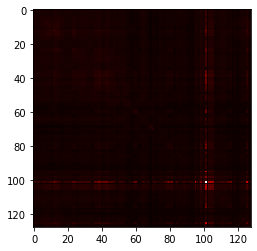

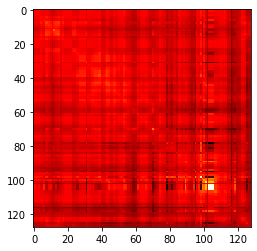

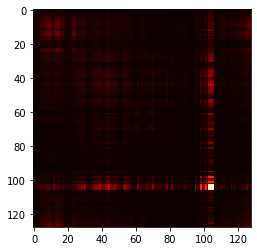

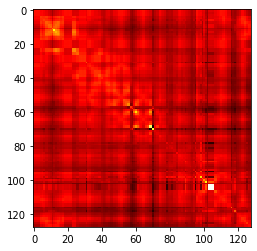

In [3]:


#Make FFT data
fftdata = ut.fftData(data)
print("FFT data shape: {}".format(fftdata.shape))

#Make covariance of FFT data
dataFFTCV = np.array(ut.fftCovariance(fftdata))
print(dataFFTCV.shape)

#Make Welch data
welchdata = ut.welchData(data, fs=256, nperseg=256)
print("Welchdata data shape: {}".format(welchdata.shape))

#Make covariance of welch data
dataWCV = np.array(ut.fftCovariance(welchdata))
print(dataWCV.shape)

#Hilbert data
dataH = hilbert(data, axis=2, N=256)
dataHR = dataH.real
dataHI = dataH.imag
print("Hilbert real data shape: {}".format(dataHR.shape))

#Make covariance of Hilber data
dataHRCV= np.array(ut.fftCovariance(dataHR))
print(dataHRCV.shape)
dataHICV= np.array(ut.fftCovariance(dataHI))
print(dataHICV.shape)

#Make covariance of non fft data
datagauss = ndimage.gaussian_filter1d(data, 5, axis=2)
dataCV = np.array(ut.fftCovariance(datagauss))
print(dataCV.shape)


#Note try PSD 


#Plot heatmaps 
def plotHeatMaps(plotData):
    plt.figure()
    plt.imshow(plotData, cmap="hot", interpolation="nearest")
    plt.show()


plotHeatMaps(dataFFTCV[2])
plotHeatMaps(dataCV[2])
plotHeatMaps(dataWCV[2])
plotHeatMaps(dataHRCV[2])



In [4]:


dataT = np.concatenate([dataWCV, dataHRCV, dataCV], axis =1 ) #, data
#dataT = dataHRCV
#dataT = dataCV2
#dataT = dataWCV

print("Data used for training and testing shape: {}".format(dataT.shape))
print("Label data used for training and testing shape: {}".format(labels.shape))

#Normalize data
dataT = keras.utils.normalize(dataT, axis=1, order=2)



Data used for training and testing shape: (100, 384, 128)
Label data used for training and testing shape: (100, 2)


In [5]:
#Splitting into training and test data

data_train, data_test, labels_train, labels_test = ut.splitData(dataT, labels, 0.8)



(80, 2)
(80, 384, 128)
(20, 384, 128)


In [6]:
import tensorflow_hub as hub


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def useBestModel(dataT, reg1 = 3, reg2 = 3, reg3 = 3, dropout = 1, layerSize = 50, activation ="relu"):
        z = reg1
        x = reg2
        y = reg3
        drpout = dropout*0.1
        lz = layerSize
        activation = activation


        eeg_model = tf.keras.Sequential([
                
                hub.KerasLayer(handle = "saved_model/best_model", input_shape=(dataT.shape[1], dataT.shape[2], 1))
        
                
                

        ])
        return eeg_model


In [7]:

print("Works for 1 subject data, 64 percent acc?")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def makeModel(dataT, reg1 = 3, reg2 = 3, reg3 = 3, dropout = 1, layerSize = 50, activation ="relu"):
    z = reg1
    x = reg2
    y = reg3
    drpout = dropout*0.1
    lz = layerSize
    activation = activation


    eeg_model = tf.keras.Sequential([
       
        
        #layers.Flatten(input_shape = data_train.shape[1]),
        layers.LocallyConnected2D(lz, [25,20], 20, 
        input_shape=(dataT.shape[1], dataT.shape[2], 1)
        
        ,activation=activation
        
        ,kernel_regularizer=regularizers.L1L2(l1=z*1e-5, l2=z*1e-4),
        bias_regularizer=regularizers.L2(z*1e-4),
        activity_regularizer=regularizers.L2(z*1e-5)

        ),

        layers.Dropout(drpout),
        layers.LocallyConnected2D(lz, [15,6], 6, 
        input_shape=(dataT.shape[1], dataT.shape[2], 1)
        
        ,activation=activation

        ,kernel_regularizer=regularizers.L1L2(l1=x*1e-5, l2=x*1e-4),
        bias_regularizer=regularizers.L2(x*1e-4),
        activity_regularizer=regularizers.L2(x*1e-5)
        ),
    
        layers.Dropout(drpout+0.1),
        layers.Dense(units=lz*4, activation=activation,
        kernel_regularizer=regularizers.L1L2(l1=y*1e-5, l2=y*1e-4),
        bias_regularizer=regularizers.L2(y*1e-4),
        activity_regularizer=regularizers.L2(y*1e-5)
        
        ),
        layers.Dropout(drpout+0.2),

        layers.Flatten(),

        layers.Dense(units=2, activation="softmax")


    ])
    return eeg_model


Works for 1 subject data, 64 percent acc?


In [14]:
def trainTestModel(eeg_model, data_train, data_test,
     labels_train, labels_test, reg, drp, lz = 50, act = "relu", best_loss=10000, saveBest = False):
     callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

     eeg_model.compile(optimizer='adam',
                    loss="binary_crossentropy",
                    metrics=['accuracy'])




     #Reshaping data to fit with neural net. 
     data_train_send = np.reshape(data_train, [data_train.shape[0], data_train.shape[1], data_train.shape[2], 1])
     data_test_send = np.reshape(data_test, [data_test.shape[0], data_test.shape[1], data_test.shape[2], 1])
     print(data_train_send.shape)


     #Training NN
     outputs = eeg_model.fit(data_train_send, labels_train, validation_split=0.2 ,callbacks=[callback], epochs=200, verbose=False) #

     #Printing results
     print("Results")
     eval = eeg_model.evaluate(data_test_send, labels_test)
     result = eeg_model.predict(data_test_send)

     #Plotting training and validation results. 
     val_loss = outputs.history["val_loss"]
     loss = outputs.history["loss"]

     if saveBest == True:
          if (np.amin(val_loss)+eval[0]) < best_loss:
               best_loss = (np.amin(val_loss)+eval[0])
               eeg_model.save('saved_model/best_model{}'.format(specificSubject))

     plt.plot(loss, 'r', label='Training loss')
     plt.plot(val_loss, 'b', label='Validation loss')
     plt.title('loss {} for reg val {} , dropout val {} ,layersize val {} and act {}'.format(round(eval[0],2),reg,drp, lz, act))
     plt.legend()
     plt.figure()
     plt.pause(0.1)

     val_acc = outputs.history["val_accuracy"]
     acc = outputs.history["accuracy"]
     plt.plot(acc, 'r', label='Training acc')
     plt.plot(val_acc, 'b', label='Validation acc')
     plt.title('acc {}  for reg val {} , dropout val {} , layersize val {} and act {}'.format(round(eval[1],2),reg,drp, lz, act))
     plt.legend()
     plt.figure()
     plt.pause(0.1)
     
     return best_loss

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected2d_2 (Loca  (None, 18, 6, 50)        2705400   
 llyConnected2D)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 18, 6, 50)         0         
                                                                 
 locally_connected2d_3 (Loca  (None, 1, 1, 50)         225050    
 llyConnected2D)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1, 1, 50)          0         
                                                                 
 dense_2 (Dense)             (None, 1, 1, 200)         10200     
                                                                 
 dropout_5 (Dropout)         (None, 1, 1, 200)        

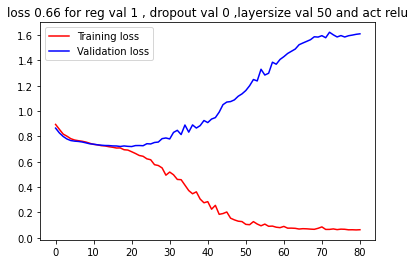

<Figure size 432x288 with 0 Axes>

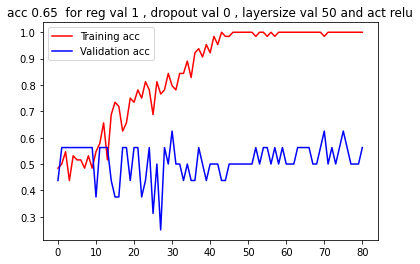

<Figure size 432x288 with 0 Axes>

reg = 1, drp = 2  lz = 50 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 524ms/step


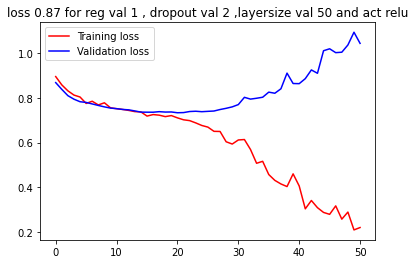

<Figure size 432x288 with 0 Axes>

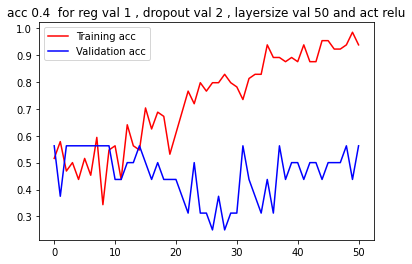

<Figure size 432x288 with 0 Axes>

reg = 3, drp = 0  lz = 50 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 525ms/step


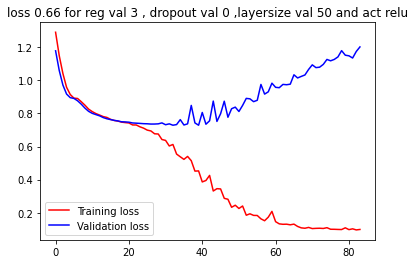

<Figure size 432x288 with 0 Axes>

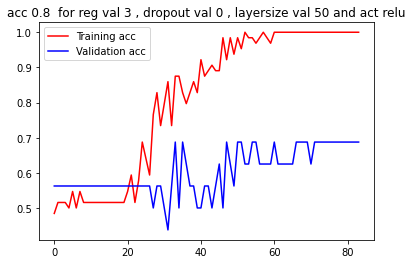

<Figure size 432x288 with 0 Axes>

reg = 3, drp = 2  lz = 50 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 530ms/step


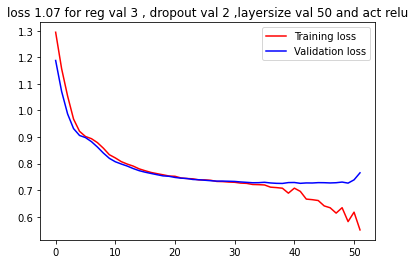

<Figure size 432x288 with 0 Axes>

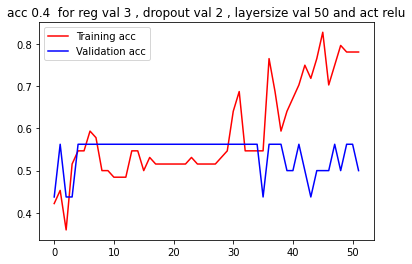

<Figure size 432x288 with 0 Axes>

reg = 1, drp = 0  lz = 100 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 529ms/step


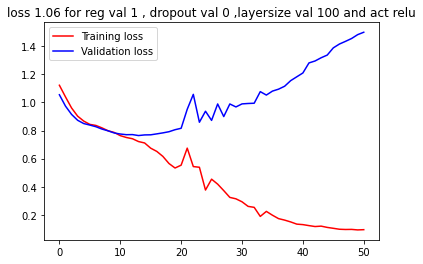

<Figure size 432x288 with 0 Axes>

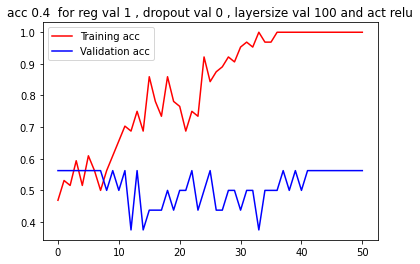

<Figure size 432x288 with 0 Axes>

reg = 1, drp = 2  lz = 100 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 534ms/step


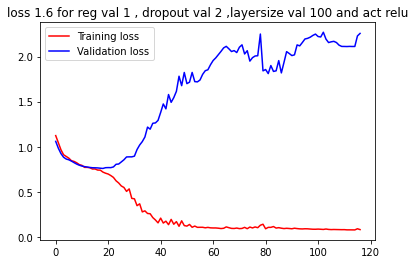

<Figure size 432x288 with 0 Axes>

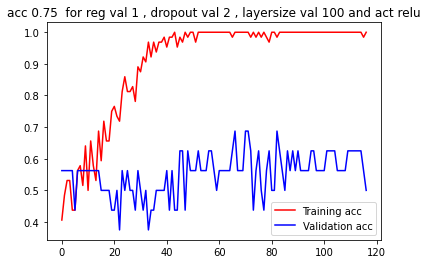

<Figure size 432x288 with 0 Axes>

reg = 3, drp = 0  lz = 100 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 524ms/step


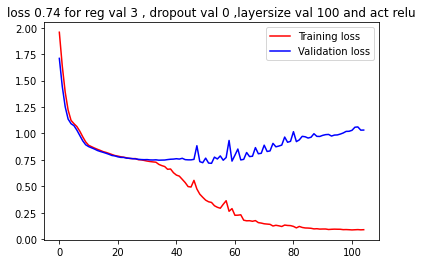

<Figure size 432x288 with 0 Axes>

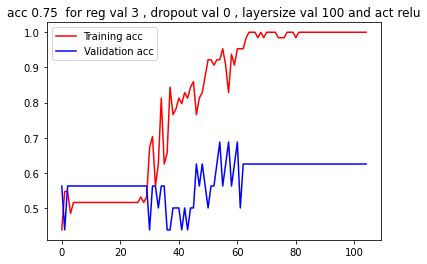

<Figure size 432x288 with 0 Axes>

reg = 3, drp = 2  lz = 100 , act = relu
(80, 384, 128, 1)
Results
1/1 [==============================] - 1s 537ms/step


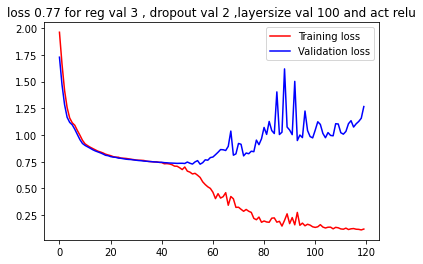

<Figure size 432x288 with 0 Axes>

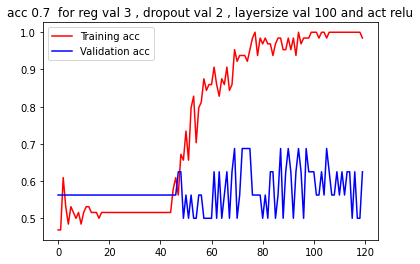

<Figure size 432x288 with 0 Axes>

In [15]:
#Make model with params
useBest = False


eeg_model = makeModel(dataT, reg1=3, reg2=3, reg3=3, dropout=1)
eeg_model.build()
eeg_model.summary()
best_loss = 1000000

if useBest == True:
    tf.keras.backend.clear_session()
    eeg_model = useBestModel(dataT)
    eeg_model.build()
    print("Training best model")
    best_loss = trainTestModel(eeg_model, data_train, data_test, labels_train, labels_test, saveBest = False, reg = 1, drp = 1)

else:
    for act in ["relu"]: #"Leaky_relu"
        for lz in [50,100]: #,50 10,10,25,
            for reg in [1,3]: #[0.5,1.5,3]
                for drp in [0,2]: #(1,2):
                    tf.keras.backend.clear_session()
                
                        
                    eeg_model = makeModel(dataT, reg1=reg, reg2=reg, reg3=reg, dropout=drp, layerSize=lz, activation=act)
                    eeg_model.build()
                    print("reg = {}, drp = {}  lz = {} , act = {}".format(reg, drp, lz, act))
                    best_loss = trainTestModel(eeg_model, data_train, data_test, labels_train, labels_test, reg, drp, lz=lz, act=act, best_loss=best_loss, saveBest = True)




In [10]:
# for act in ["tanh"]:
#     for lz in [10,25]: #,50
#         for reg in [0.5,4,8]:
#             for drp in [1,3,5]:
#                 tf.keras.backend.clear_session()
#                 eeg_model = makeModel(dataT, reg1=reg, reg2=reg, reg3=reg, dropout=drp, layerSize=lz, activation=act)
#                 eeg_model.build()
#                 print("reg = {}, drp = {}  lz = {} , act = {}".format(reg, drp, lz, act))
#                 trainTestModel(eeg_model, data_train, data_test, labels_train, labels_test, reg, drp, lz=lz, act=act)


In [11]:

eeg_model.save('saved_model/my_modelgood4')

INFO:tensorflow:Assets written to: saved_model/my_modelgood4\assets
